# Get a transfer function

In [1]:
mcnums = 1024

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [3]:
nside = 64

In [4]:
Npix = hp.nside2npix(nside)
lmax = 3 * nside - 1
sigmab = hp.nside2resol(nside)
fwhm = (8*np.log(2))**0.5 * sigmab
print('nside:{:}, Npix:{:}, res:{:.1f} deg, sigmab:{:.1f} deg, fwhm:{:.1f} deg'.
      format(nside, Npix, np.rad2deg(hp.nside2resol(nside)), np.rad2deg(sigmab), np.rad2deg(fwhm)))

nside:64, Npix:49152, res:0.9 deg, sigmab:0.9 deg, fwhm:2.2 deg


In [13]:
prefix = 'scan_masked_apodization'
Z = apodization = np.array(hp.read_map('{:}_nside{:03d}.fits'.format(prefix,nside)))
#hp.mollview(np.ma.masked_array(apodization, mask=~mask, fill_value=hp.UNSEEN), title='Used apodization, ring')

## preparation of camb

In [6]:
import camb

In [7]:
%%time
pars = camb.CAMBparams()
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0.2)
pars.set_for_lmax(4000, lens_potential_accuracy=1)
pars.set_accuracy(AccuracyBoost=1)
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.WantTensors = True
pars.max_l_tensor = 1600
pars.max_eta_k_tensor = 3200
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
print(powers.keys())

dict_keys(['total', 'unlensed_scalar', 'unlensed_total', 'lensed_scalar', 'tensor', 'lens_potential'])
CPU times: user 2min 5s, sys: 1.07 s, total: 2min 6s
Wall time: 1.59 s


In [8]:
def dl2cl(l,dl):
    return dl/l/(l+1)*2*np.pi

def cl2dl(l,cl):
    return l*(l+1)*cl/2/np.pi

def get_cls(key, teb='teb'):
    #total
    #unlensed_scalar
    #unlensed_total
    #lensed_scalar
    #tensor
    #ens_potential
    Dls = powers[key]
    ell = np.arange(Dls.shape[0])
    ell[0] = 1.
    cltt, clee, clbb, clte = dl2cl(ell, Dls.T)
    if teb == 'te':
        clbb = np.zeros_like(cltt)
    elif teb == 'tb':
        clte = clee = np.zeros_like(cltt)

    cltb = cleb = np.zeros_like(cltt)
    # a list of cl’s (TT, EE, BB, TE, EB, TB for polarized input map)
    return cltt,clee,clbb,clte,cleb,cltb

## preparation of transfer functions

In [9]:
import pymaster as nmt

delta_ell = 9 # this never change mll
ls = np.arange(lmax+1)
bl = np.exp(-ls*(ls+1)*sigmab*sigmab*0.5)

I,Q,U = map0 = np.zeros(shape=(3,Npix))
nmt_l = nmt.NmtBin.from_nside_linear(nside, delta_ell, is_Dell=False)
for label,purify_b in zip(('','_no_KS_purif'),(True,False)):
    f2 = nmt.NmtField(apodization, [Q, U], purify_e=False, purify_b=purify_b)
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f2, f2, nmt_l)
    mll = w.get_coupling_matrix()
    np.save('nmt_mode_coupling_matrix{:}'.format(label), mll)
            
dicCls = {}
dicCLs = {}
np.random.seed(0)
for teb, flavor in zip(('te', 'tb', 'teb'),('ttee', 'ttbb', 'tteebb')):
    # LCDM; 
    key = 'total'
    Cls = get_cls(key, teb=teb) # sim input w/o beam
    l = ls = np.arange(len(Cls[0]))
    Dls = l*(l+1)/2./np.pi*Cls
    CLs = Cls * np.exp(-l*(l+1)*sigmab**2) # w/ beam for reference
    dicCls[flavor] = Cls
    dicCLs[flavor] = CLs
    DLs = cl2dl(l,CLs)

## calculate transfer functions

In [10]:
def fl_itr(fl, simcl, mll, bcl):
    return fl + (simcl - np.dot(mll, fl * bcl)) / bcl

def auto_transfer_function_itr(theorycl, simcl, bl, mll, niter=3):
    norm = mll.shape[0] / np.sum(mll)
    nmll = mll * norm
    bcl = theorycl * bl * bl
    fl_i = simcl / bcl
    for i in range(niter):
        fl_i = fl_itr(fl_i, simcl, nmll, bcl)

    return fl_i

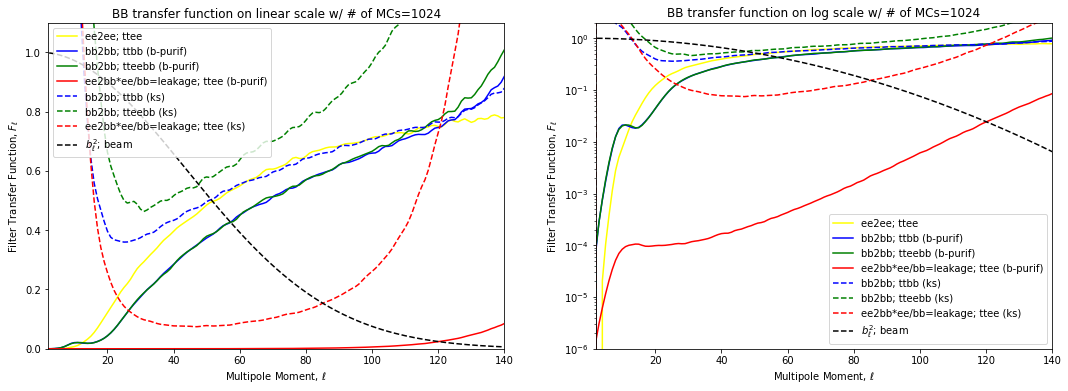

In [11]:
fig,axes = plt.subplots(1,2, figsize=(18,6))
# fiducial theory
Cls = dicCls['tteebb']
ee = Cls[1][:lmax+1]
bb = Cls[2][:lmax+1]

# for ee
iflavor = 1
# KS
itype = 2
mll = np.load('nmt_mode_coupling_matrix_no_KS_purif.npy')[iflavor::4,iflavor::4]
    
## theory compared to Fl
theorycl = Cls[iflavor][:lmax+1]
theorycl[:2] = theorycl[2]
## ttee
simcl = np.load('sim_ttee_avg_mc{:04d}.npy'.format(mcnums))[itype][iflavor]
fl_ee_ttee = auto_transfer_function_itr(theorycl, simcl, bl, mll)
ls = np.arange(lmax+1)

for i,(scale,minmax) in enumerate(zip(('linear', 'log'),((0,1.1),(1e-6,2)))):
    ax = axes[i]
    ## ee
    ax.plot(ls, fl_ee_ttee, 'yellow', label='ee2ee; ttee')

    # 0:TT, 1: EE, 2: BB
    iflavor = 2
    # 0:input, 1: binned, 2: KS purification, 3: KS no purification, 4: B purification
    # B-purification
    itype = 4
    mll = np.load('nmt_mode_coupling_matrix_no_KS_purif.npy')[iflavor::4,iflavor::4]
    
    # theory compared to Fl
    theorycl = Cls[iflavor][:lmax+1]
    theorycl[:2] = theorycl[2]

    ## ttbb
    simcl = np.load('sim_ttbb_avg_mc{:04d}.npy'.format(mcnums))[itype][iflavor]
    fl = fl_bb_ttbb = auto_transfer_function_itr(theorycl, simcl, bl, mll)
    ax.plot(ls, fl, 'b', label='bb2bb; ttbb (b-purif)')

    ## tteebb
    simcl = np.load('sim_tteebb_avg_mc{:04d}.npy'.format(mcnums))[itype][iflavor]
    fl = fl_bb_tteebb = auto_transfer_function_itr(theorycl, simcl, bl, mll)
    ax.plot(ls, fl, 'g', label='bb2bb; tteebb (b-purif)')

    ## ttee for leakage
    simcl = np.load('sim_ttee_avg_mc{:04d}.npy'.format(mcnums))[itype][iflavor]
    fl = fl_ee2bb = auto_transfer_function_itr(theorycl, simcl, bl, mll)
    ax.plot(ls, fl, 'r', label='ee2bb*ee/bb=leakage; ttee (b-purif)')

    # KS
    itype = 2
    mll = np.load('nmt_mode_coupling_matrix.npy')[iflavor::4,iflavor::4]

    ## ttbb
    simcl = np.load('sim_ttbb_avg_mc{:04d}.npy'.format(mcnums))[itype][iflavor]
    fl = fl_bb_ttbb_ks = auto_transfer_function_itr(theorycl, simcl, bl, mll)
    ax.plot(ls, fl, 'b--', label='bb2bb; ttbb (ks)')

    ## tteebb
    simcl = np.load('sim_tteebb_avg_mc{:04d}.npy'.format(mcnums))[itype][iflavor]
    fl = fl_bb_tteebb_ks = auto_transfer_function_itr(theorycl, simcl, bl, mll)
    ax.plot(ls, fl, 'g--', label='bb2bb; tteebb (ks)')

    ## ttee for leakage
    simcl = np.load('sim_ttee_avg_mc{:04d}.npy'.format(mcnums))[itype][iflavor]
    fl = fl_ee2bb_ks = auto_transfer_function_itr(theorycl, simcl, bl, mll)
    ax.plot(ls, fl, 'r--', label='ee2bb*ee/bb=leakage; ttee (ks)')

    ax.plot(ls, bl**2, 'k--', label=r"$b_\ell^2$; beam")
    ax.set_ylim(minmax)
    ax.set_xlim(2, 140)

    ax.set_xlabel(r"Multipole Moment, $\ell$")
    ax.set_ylabel(r"Filter Transfer Function, $F_\ell$")
    ax.set_title('BB transfer function on {:} scale w/ # of MCs={:}'.format(scale, mcnums))
    ax.legend()    
    ax.set_yscale(scale)
    
    if scale == 'linear':
        np.savez("bb_transfer_functions_mc{:04d}".format(mcnums),
                fl_ee=fl_ee_ttee, 
                fl_bb_ttbb=fl_bb_ttbb,
                fl_bb_tteebb=fl_bb_tteebb,
                fl_ee2bb=fl_ee2bb,
                fl_bb_ttbb_ks=fl_bb_ttbb_ks,
                fl_bb_tteebb_ks=fl_bb_tteebb_ks,
                fl_ee2bb_ks=fl_ee2bb_ks
                )